In [5]:
import os
import pandas as pd
import numpy as np

In [2]:
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import FrenchStemmer
import langdetect

In [3]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [6]:
dir_path =r'C:\Users\Lenovo\Documents\cours_dataminig\newsgroups_data'
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep=';', header=None,engine='python')
articles= get_files(dir_path=dir_path, filename='articles.csv')

In [7]:
articles.columns=['articles']

In [8]:
articles_df=articles.copy()

In [6]:
articles_df.shape

(121, 1)

In [7]:
tokenize_regex = "(\w+)|(\w+(-\w+)+)"
tokenize_regex = "\w+|\w+-\w+"

french_stemmer1 = SnowballStemmer('french')
french_stemmer2 = FrenchStemmer()
stop_words_fr = stopwords.words('french')

MIN_CLEAN_TOKENS = 4

def preprocess_text(doc):
   
    

    #  lowercasing
    doc = doc.lower()

    #  remove noise/unwanted characters; this is already accomplished by tokenization process.

    ## tokenization
    tokens = regexp_tokenize(doc,tokenize_regex)

    ## post-tokenization document processing

    #   remove stopwords and one-letter words
    tokens = [tok for tok in tokens if (tok not in stop_words_fr and len(tok)>5)]

    #   stemming
    tokens = [french_stemmer1.stem(tok) if len(tok)>=7 else tok for tok in tokens]

    #   word ngrams instead of 1grams

    #   remove documents that are too short  (return [])
    if len(doc) < MIN_CLEAN_TOKENS:
        return []

    return tokens



In [8]:
articles_df['articles_'] = articles_df['articles'].map(preprocess_text)
articles_df.head()

,articles,articles_
0,"""«Touensa jew» (les tunisiens sont arrivés) es...","[touens, tunisien, arriv, repris, commenc, rés..."
1,"'Créé en 1951, ""Sanremo Giovani"" est un concou...","[sanremo, giovan, concour, musical, italien, c..."
2,"""Après avoir chanté durant plus d'une heure, S...","[chanté, durant, obligé, arrêt, concert, intem..."
3,'Le chanteur de rock français Dick Rivers est ...,"[chanteur, franc, rivers, décédé, mercred, ann..."
4,"'Après 12 mois de problèmes de santé, Céline D...","[problem, céline, annonc, import, compte, inst..."


In [9]:

idx = articles_df['articles_'].map(lambda doc: doc==[])
print("Number of dropped rows:", idx.sum())
articles_df.drop(labels=articles_df.index[idx], axis=0,inplace=True)
articles_df.shape

Number of dropped rows: 4


(117, 2)

### Key Word Extraction Using gensim

In [10]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import LsiModel, LdaModel, CoherenceModel
from gensim.models.word2vec import Word2Vec
from gensim import similarities

In [11]:
dictionary = Dictionary(articles_df['articles_'].tolist())
len(dictionary)

2251

In [12]:
from six import iteritems
MIN_TOKEN_DOC_FREQ = 5

idx = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq < MIN_TOKEN_DOC_FREQ]
print("Number of rare words:", len(idx))
dictionary.filter_tokens(idx) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
len(dictionary)

Number of rare words: 2065


186

In [13]:
vocab_list = list(dictionary.token2id.keys())


In [14]:
corpus_tokenized = articles_df['articles_'].tolist()
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokenized]

In [15]:
type(corpus_bow),len(corpus_bow)

(list, 117)

In [16]:
def calcul_freq_indice(ind):
    s=0
    for i in range(0,len(corpus_bow)):
        for j in corpus_bow[i]:
            if j[0]==ind:
                s=s+j[1]
    return (s)

In [17]:
dicti={}
for i in range(len(dictionary)):
    dicti[i]=calcul_freq_indice(i)
    

dict_sorted={k: v for k, v in sorted(dicti.items(), key=lambda item: item[1],reverse=True)}
j=0
most_vocab=""
for i in dict_sorted.items():
        j=j+1
        if j<=22:
            print(vocab_list[i[0]],i[1])
            most_vocab=most_vocab+vocab_list[i[0]]+" "
        else :
            break

chanson 76
artist 58
chanteux 50
tunisien 47
concert 47
nouvel 45
festival 44
musiqu 42
chanteur 40
groupe 36
derni 34
musical 32
public 32
annonc 28
depuis 26
programm 26
premi 24
rappeur 24
international 23
spectacl 23
meilleur 23
plusieur 22


In [18]:
most_vocab

'chanson artist chanteux tunisien concert nouvel festival musiqu chanteur groupe derni musical public annonc depuis programm premi rappeur international spectacl meilleur plusieur '

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(most_vocab)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Key Word Extraction Using SPACY

In [1]:
import spacy
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


In [9]:
articles_df2=articles.copy()

In [14]:
tokenize_regex = "(\w+)|(\w+(-\w+)+)"
tokenize_regex = "\w+|\w+-\w+"

french_stemmer1 = SnowballStemmer('french')
french_stemmer2 = FrenchStemmer()
stop_words_fr = stopwords.words('french')

MIN_CLEAN_TOKENS = 3
sp = spacy.load("fr_core_news_sm")
tokens=[]
def preprocess_text(doc):
    tokens=[]
    if langdetect.detect(doc)!='fr': return []

    doc = doc.lower()

   
    sentence = sp(doc)
    for word in sentence:
        tokens.append(word.text)
      
    

    tokens = [tok for tok in tokens if (tok not in stop_words_fr and len(tok)>3)]

 
    tokens = [french_stemmer1.stem(tok) if len(tok)>=7 else tok for tok in tokens]

    if len(doc) < MIN_CLEAN_TOKENS:
        return []

    return tokens
articles_df2['articles_'] = articles_df2['articles'].map(preprocess_text)

In [15]:
articles_df2['articles_'] .head()

0    [touens, tunisien, arriv, titre, repris, bella...
1    [créé, 1951, sanremo, giovan, concour, musical...
2    [après, avoir, chanté, durant, plus, heure, sa...
3    [chanteur, rock, franc, dick, rivers, décédé, ...
4    [après, mois, problem, santé, céline, dion, fa...
Name: articles_, dtype: object

In [26]:
s=''
for i in range(articles_df2.shape[0]):
    s=s+' '.join(articles_df2.loc[i,'articles_'])

In [22]:

import spacy
from spacy.matcher import Matcher
import math
import re
from collections import Counter

In [25]:
nlp = spacy.load("fr_core_news_sm")
phrases = []

def collect_sents(matcher, doc, i, matches):
    id_, k, l = matches[i]
    s = doc[k : l]
    phrases.append(s.lemma_)
    
patterns = [[{'POS': 'NOUN', 'IS_ALPHA': True, 'IS_STOP': False, 'OP': '+'}]]
matcher = Matcher(nlp.vocab)
for p in patterns:
    matcher.add('keyword', collect_sents, p)

def extract_keywords(text,num_keywords):
    global phrases
    
    pagenlp = nlp(text)
    phrases = []
    matches = matcher(pagenlp)
    keywords = dict(Counter(phrases).most_common(100))
    d = {}
    
    for keyword in sorted(keywords.keys()):
        terms = list(filter(lambda t: t != keyword and re.match('\\b%s\\b' % keyword, t), keywords.keys()))
        d[keyword] = keywords[keyword]
        
        
        for pt in terms:
            d[keyword] -= float(keywords[pt])/float(len(terms))
        d[keyword] *= 1 + math.log(len(keyword.split()), 2)
    best_keywords = []
    
    
    for keyword in sorted(d, key=d.get, reverse=True)[:num_keywords]:
        best_keywords.append([keyword, d[keyword]])
    return best_keywords



In [42]:

best_keywords=extract_keywords(s,20)


In [43]:
for i in range(len(best_keywords)):
    l=l+best_keywords[i][0]+" "
l

'chanson groupe concert août scène année titre tunisien lieu artist mars chanteur plusieur succès million musicien soirée jour juillet rappeur samedi indiqu mois projet soir mardi fois voix heure juin chanson groupe concert août scène année titre tunisien lieu artist mars chanteur plusieur succès million musicien soirée jour juillet rappeur samedi indiqu mois projet soir mardi fois voix heure juin chanson groupe concert août scène année titre tunisien lieu artist mars chanteur plusieur succès million musicien soirée jour juillet rappeur '

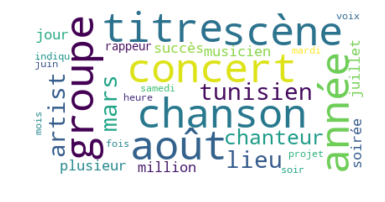

In [44]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(l)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()